In [179]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED=321
np.random.seed(SEED)
## set text displays for sklearn
from sklearn import set_config
set_config(display="text")
## Using pd.set_option to display more columns
pd.set_option("display.max_columns", 0)

# Plot Styles

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
fav_style = ("ggplot", "tableau-colorblind10")
fav_context = {"context":"notebook", "font_scale":1.2}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams["savefig.transparent"] = False
plt.rcParams["savefig.bbox"] ="tight"

# Preprocessing

In [181]:
## Load in the student performance - Portuguese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"
df = pd.read_excel(url,sheet_name='student-por')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12


# Calculating Letter Grades from G3


We want to determine which students will receive an F for their G3 score. Right now, we have the grades as values out of 20.

The school informed us that when they determine letter grades, they:

First, convert the raw scores out of 20 into % out of 100.

Bin the % grades to determine the letter:

* 'A': if G3>=90
* 'B': if G3>= 80 & G3 <90
* 'C': if G3>= 70 & G3 <80
* 'D': if G3>= 60 & G3 < 70
* 'F': if G3 is <60

Our first task is to convert the G3 scores into %'s.

In [182]:
## convert G3 to a % out of 100
df["G3(%)"] = (df["G3"]/20) * 100
df["G3(%)"].head()

0    55.0
1    55.0
2    60.0
3    70.0
4    65.0
Name: G3(%), dtype: float64

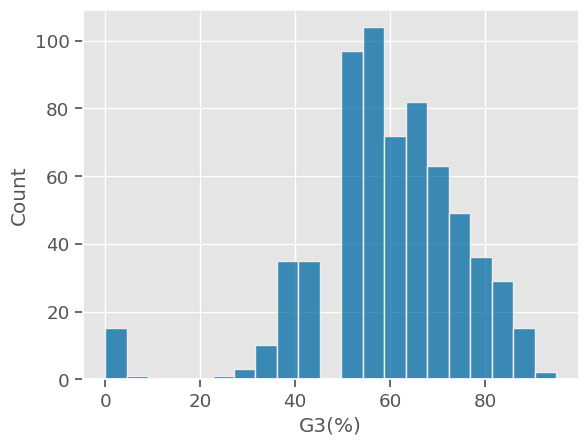

In [183]:
## visual distribution of % grades
ax = sns.histplot(df, x="G3(%)")

# Using pd.cut

defines the span of each bin or by defaults makes its own.

In [184]:
## defining bin edges, meaning the actual value span for each bin 
#in this case the first bin, G3 score from 0-60 is an "F"
bins = [0,60,70,80,90,100]
grades = pd.cut(df["G3(%)"], bins=bins)
grades.value_counts().sort_index()

(0, 60]      358
(60, 70]     145
(70, 80]      85
(80, 90]      44
(90, 100]      2
Name: G3(%), dtype: int64

In [185]:
#If we say right=False, then the logic will change to match what we wanted, where scores up to 60 (but not 60)
grades = pd.cut(df["G3(%)"], bins=bins, right=False)
grades.value_counts(dropna=False)

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 100)     17
Name: G3(%), dtype: int64

The downside to this approach is that 100 will no longer be included in the last bin, so we would to increase the final bin edge to 101.

In [186]:
bins = [0,60,70,80,90,101]
grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts()

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 101)     17
Name: G3(%), dtype: int64

## Adding Bin labels and saving as a column


In [187]:
## defining bins and their labels
bins = [0,60,70,80,90,101]
bin_labels = ['F','D','C','B','A']
grades = pd.cut(df["G3(%)"], bins, labels=bin_labels, include_lowest=True)
grades.value_counts()

F    373
D    145
C     85
B     44
A      2
Name: G3(%), dtype: int64

In [188]:
#add these values to our DataFrame as a new column 'FinalGrade'.
df["FinalGrade"] = pd.cut(df["G3(%)"], bins, labels=bin_labels, include_lowest=True)
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G3(%),FinalGrade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11,55.0,F
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11,55.0,F
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12,60.0,F
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14,70.0,D
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13,65.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,course,mother,1,3,1,no,no,no,yes,no,yes,yes,no,5,4,2,1,2,5,4,10,11,10,50.0,F
645,MS,F,18,U,LE3,T,3,1,teacher,services,course,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,3,4,1,1,1,4,15,15,16,80.0,C
646,MS,F,18,U,GT3,T,1,1,other,other,course,mother,2,2,0,no,no,no,yes,yes,yes,no,no,1,1,1,1,1,5,6,11,12,9,45.0,F
647,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,6,10,10,10,50.0,F


In [189]:
## We can group by the letter grades and get the min/max of the scores to confirm 
df.groupby("FinalGrade")["G3(%)"].agg(["min", "max", "count"])

,min,max,count
FinalGrade,,,
F,0.0,60.0,373
D,65.0,70.0,145
C,75.0,80.0,85
B,85.0,90.0,44
A,95.0,95.0,2


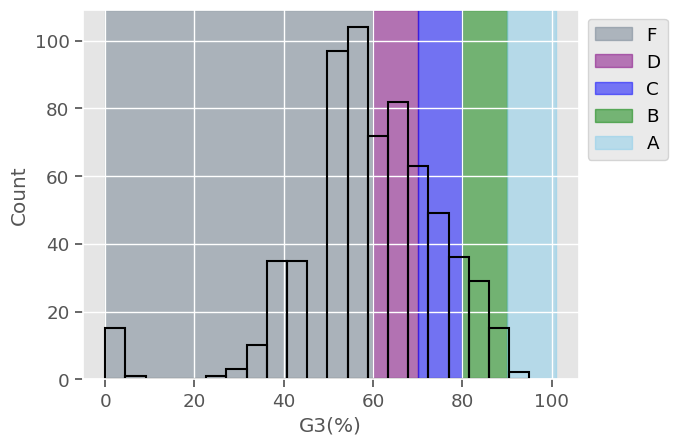

In [190]:
#color-coded regions for each letter grade
## visualizing the cutoffs for grades
ax = sns.histplot(data=df, x='G3(%)',color='k',fill=False)
colors = ['slategray','purple','blue','green','skyblue']
for i in range(len(bins)-1):
    x1 = bins[i]
    x2 = bins[i+1]
    label = bin_labels[i]
    ax.axvspan(x1,x2, label=label,color=colors[i],zorder=0,alpha=.5)
ax.legend(bbox_to_anchor=[1,1]);   

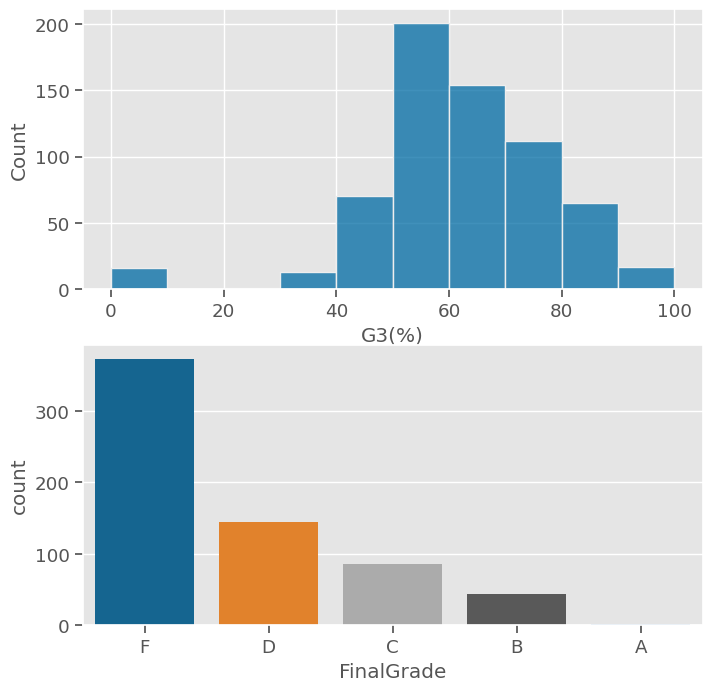

In [191]:
#We can also view these distributions on two separate graphs.
fig, axes = plt.subplots(nrows=2,figsize=(8,8))
sns.histplot(data=df, x='G3(%)',ax=axes[0], binwidth=10);
sns.countplot(data=df,x='FinalGrade',ax=axes[1],order=['F','D','C','B','A']);

# Making Our Final Target & X/y Data

In [192]:
## Define target as had a F or Above
df["target_F"] = df["FinalGrade"] == "F"
df["target_F"].value_counts(normalize=True)

True     0.57473
False    0.42527
Name: target_F, dtype: float64

# Train Test Split



In [193]:
## Make x and y variables
drop_feats = ['G1','G2','G3','G3(%)','FinalGrade']
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
54,GP,F,15,U,LE3,A,3,3,other,other,other,mother,1,1,0,no,no,no,no,yes,yes,yes,no,5,3,4,4,4,1,0
208,GP,M,16,U,GT3,T,2,3,other,other,home,father,2,1,0,no,no,no,no,yes,yes,yes,no,5,3,3,1,1,3,0
23,GP,M,16,U,LE3,T,2,2,other,other,reputation,mother,2,2,0,no,yes,no,yes,yes,yes,yes,no,5,4,4,2,4,5,2
547,MS,M,16,R,LE3,T,4,1,other,at_home,other,father,1,1,0,no,no,no,no,yes,yes,yes,no,4,1,2,2,1,2,0
604,MS,F,18,U,GT3,T,1,1,at_home,services,course,mother,3,2,1,no,no,no,no,yes,no,no,no,4,4,2,1,2,2,2


# Preprocessing and Column Transformers



In [194]:
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                     fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.0,3.0,4.0,1.0,2.0,0.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
284,18.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,5.0,2.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
579,18.0,1.0,3.0,1.0,1.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


# RandomForestClassifier

## Function for Evaluating Classification Models


In [195]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()



--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



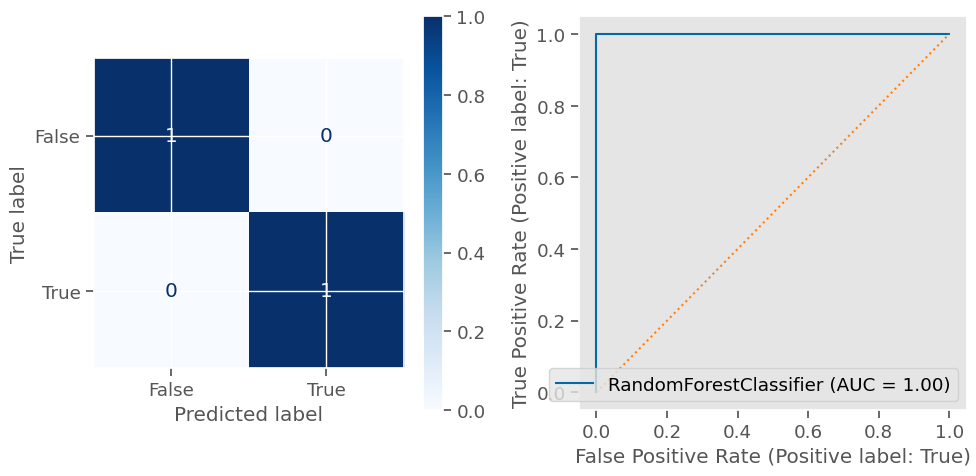

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



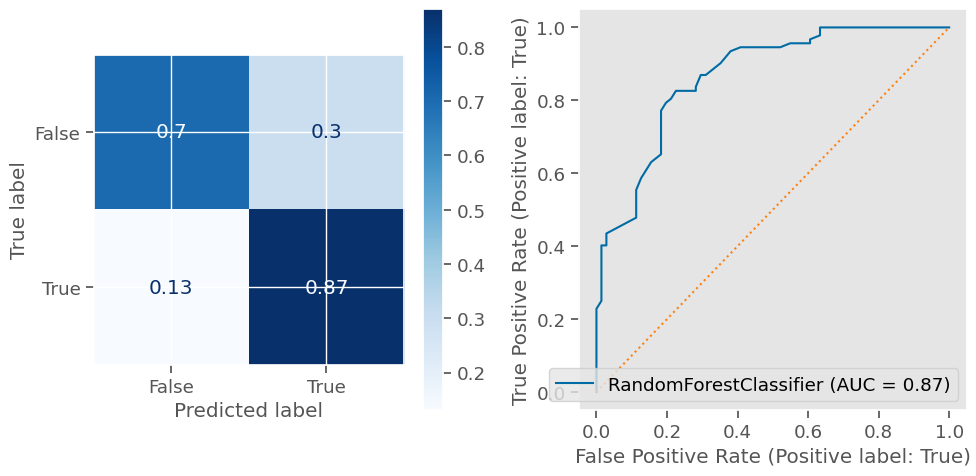

In [196]:
## fit random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()#class_weight='balanced')
rf_clf.fit(X_train_df, y_train)
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

In [197]:
#Defining a Function for Feature Importance
def get_importances(model, feature_names=None, name="Feature Importance",
                    sort=False, ascending=True):
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index=feature_names, name=name)
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

In [198]:
#Create a custom function to plot our importances
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    fig2, ax = plt.subplots()
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    plt.tight_layout();
    ## return ax in case want to continue to update/modify figure
    return ax

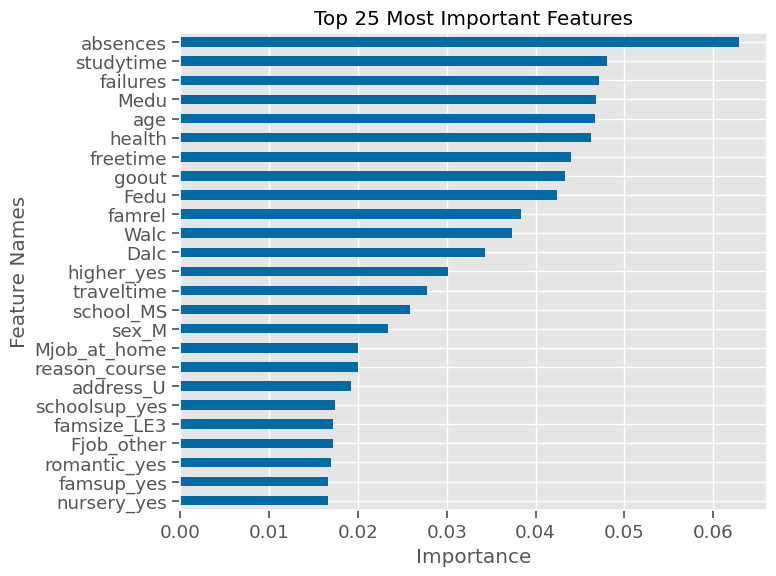

In [199]:
#plotting RandomForest model's top 25 important features
rf_importances = get_importances(rf_clf)
ax = plot_importance(rf_importances, top_n=25)

# Permutation Importances - RandomForest

In [200]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_clf,X_train_df,y_train,n_jobs=-1,n_repeats=5)
r.keys()


dict_keys(['importances_mean', 'importances_std', 'importances'])

In [201]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [202]:
## getting the colors for the top 7 important rf features
colors_rf = get_color_dict(rf_importances, top_n=7)

In [203]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax


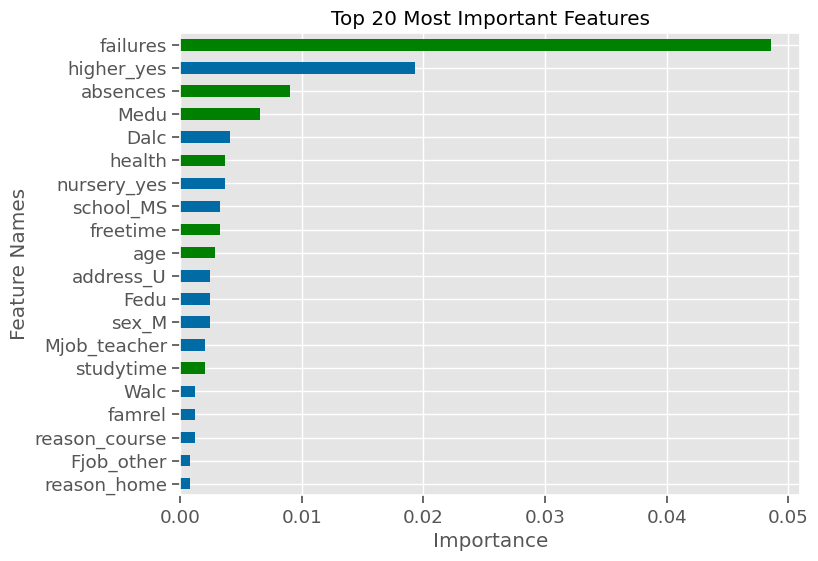

In [204]:
## can make the mean importances into a series
rf_perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)
plot_importance_color(rf_perm_importances, color_dict=colors_rf, top_n=20);



# Post-Modeling EDA


In [205]:
# Combining all data for eda post-modeling
plot_df_train = pd.concat([X_train_df, y_train],axis=1)
plot_df_test = pd.concat([X_test_df, y_test],axis=1)
plot_df = pd.concat([plot_df_train, plot_df_test])
plot_df

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,target_F
54,15.0,3.0,3.0,1.0,1.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
208,16.0,2.0,3.0,2.0,1.0,0.0,5.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
23,16.0,2.0,2.0,2.0,2.0,0.0,5.0,4.0,4.0,2.0,4.0,5.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,True
547,16.0,4.0,1.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
604,18.0,1.0,1.0,3.0,2.0,1.0,4.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,17.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,False
454,16.0,1.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,4.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,True
56,15.0,4.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,False
203,17.0,1.0,2.0,1.0,2.0,0.0,3.0,1.0,3.0,1.0,5.0,3.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True


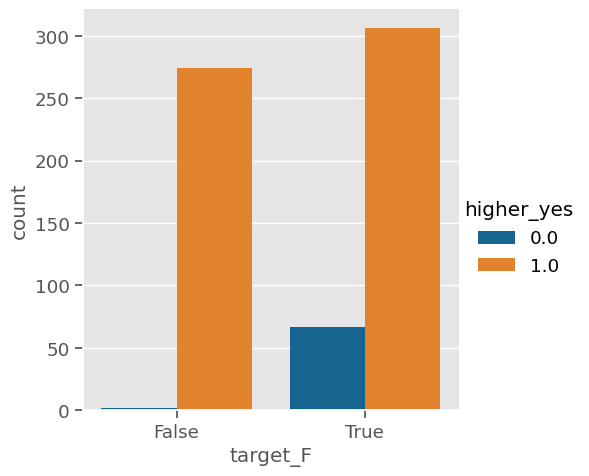

In [206]:
#the relationship between our target and the top 3 features.
sns.catplot(plot_df, kind="count", x="target_F", hue="higher_yes");

As we can see with our EDA above, it looks like there are a higher proportion of students that are NOT pursuing higher education (blue group) in the Failing students (target_F==True) than the successful students.

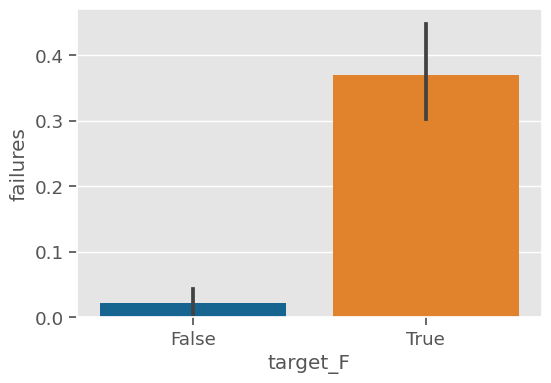

In [207]:
plt.figure(figsize=(6,4))
ax = sns.barplot(plot_df, x="target_F", y="failures")

We can see above that students who failed Portuguese had many more failures, on average

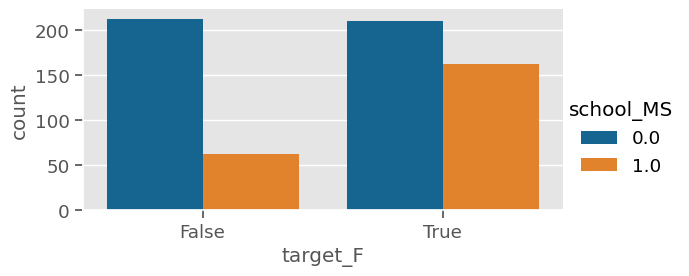

In [208]:
sns.catplot(plot_df, kind='count', x='target_F', hue='school_MS',
            aspect=2, height=3);

doesnt seem that school_MS had much of a difference on the target_F group.

# Converting Our Linear Equation to A Sigmoid Curve


In [209]:
#define a simple function to solve this equation when various values of x are give
def cal_lin_reg(x):
    return x * 2.713 - .8

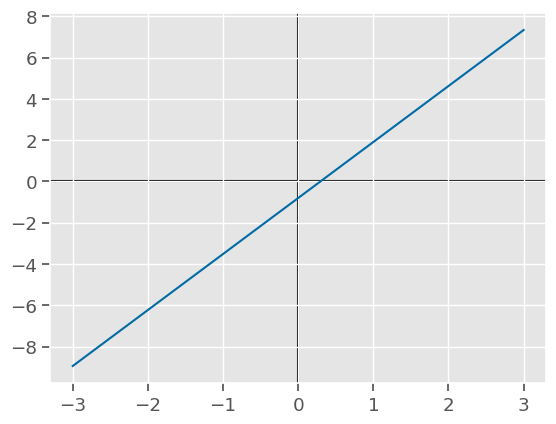

In [210]:
#plot our line
xs = np.linspace(-3,3)
ys = cal_lin_reg(xs)

def plot_xy(xs,ys):
    plt.plot(xs,ys)
    plt.axvline(0, color="k", zorder=0)
    plt.axhline(0, color="k", zorder=0)
    
plot_xy(xs,ys)    

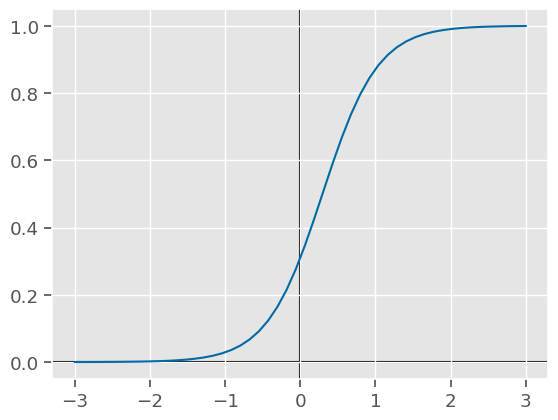

In [211]:
from math import e
def calc_sigmoid(ys):
    return 1/(1+e**-ys)
ys_sigmoid = calc_sigmoid(ys)
plot_xy(xs, ys_sigmoid)

values above .5 will be classified as 1 while values below .5 will be classified as 0.

# LogisticRegression in sklearn


--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       0.73      0.71      0.72       205
        True       0.79      0.81      0.80       281

    accuracy                           0.77       486
   macro avg       0.76      0.76      0.76       486
weighted avg       0.76      0.77      0.76       486



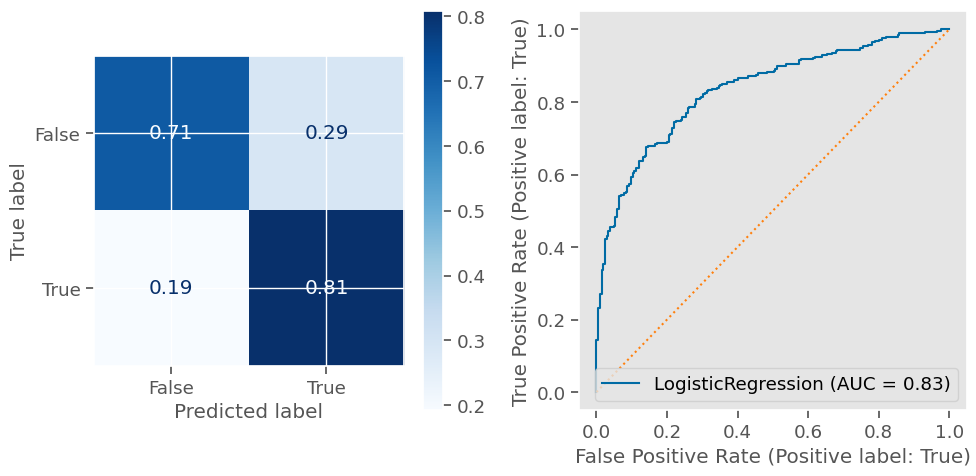

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.73      0.69      0.71        71
        True       0.77      0.80      0.79        92

    accuracy                           0.75       163
   macro avg       0.75      0.75      0.75       163
weighted avg       0.75      0.75      0.75       163



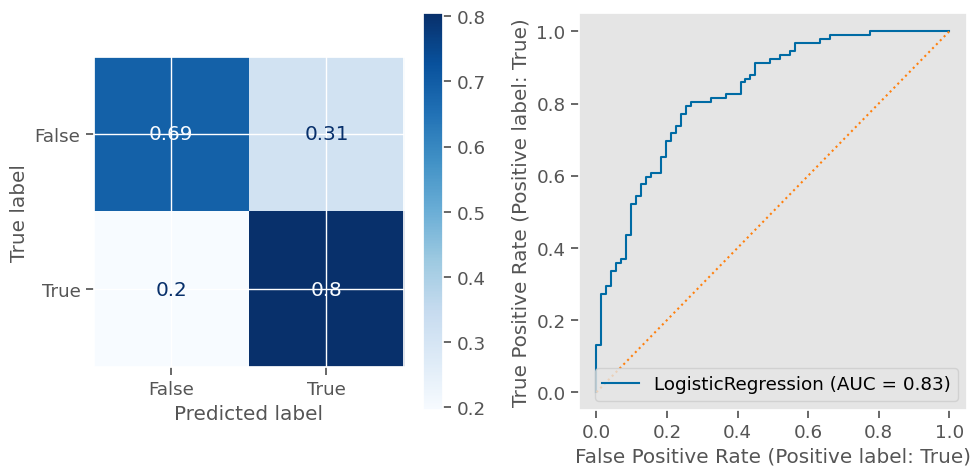

In [212]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_df, y_train)
evaluate_classification(logreg,X_train_df,y_train, X_test_df,y_test)

As we can see above, our LogisticRegression model did not perform quite as well as our RandomForest, but it is still performing well-enough that it is worth extracting our coefficients and getting additional insights into the directionality of the effect of each feature on the target.


## Extracting Coefficients from LogisticRegression in scikit-learn

In [213]:
try:
    get_coeffs_linreg(logreg)
except Exception as e:
    print("ERROR: ", e) 


ERROR:  Length of values (1) does not match length of index (43)


We got an error when we tried to make our coef's into a pd.Series. The reason for this is that we have an extra empty matrix around our coefficients.


In [214]:
#Notice the shape of our .coef_ below has an extra first dimension added:
logreg.coef_

array([[-0.22026998, -0.1864845 , -0.2155655 , -0.33692149, -0.37128056,
         1.39681421, -0.25645009,  0.10210112,  0.12243967,  0.43146144,
        -0.11759159,  0.13289996,  0.07235481,  0.62767646,  0.61181655,
        -0.32468842,  0.13829878,  0.19589564,  0.41603881, -0.35064931,
        -0.19727801,  0.01610989,  0.11456672, -0.30301141,  0.3797045 ,
         0.3257084 ,  0.29032486, -0.69393824,  0.16762929, -0.38956819,
         0.21859111,  0.00213588, -0.14328622, -0.05469348,  0.19676779,
         0.94175742,  0.13837739,  0.12484515, -0.18643768, -0.07990816,
        -1.70526367, -0.07333897,  0.19177627]])

In [215]:
#the intercept_ (which was a single value in LinearRegression mode) is now also wrapped in an array.
logreg.intercept_

array([6.27093976])

## Slicing LogReg Coefficients


In [216]:
logreg.coef_[0]


array([-0.22026998, -0.1864845 , -0.2155655 , -0.33692149, -0.37128056,
        1.39681421, -0.25645009,  0.10210112,  0.12243967,  0.43146144,
       -0.11759159,  0.13289996,  0.07235481,  0.62767646,  0.61181655,
       -0.32468842,  0.13829878,  0.19589564,  0.41603881, -0.35064931,
       -0.19727801,  0.01610989,  0.11456672, -0.30301141,  0.3797045 ,
        0.3257084 ,  0.29032486, -0.69393824,  0.16762929, -0.38956819,
        0.21859111,  0.00213588, -0.14328622, -0.05469348,  0.19676779,
        0.94175742,  0.13837739,  0.12484515, -0.18643768, -0.07990816,
       -1.70526367, -0.07333897,  0.19177627])

In [217]:
logreg.intercept_[0]


6.270939759127006

## Writing a get_coeffs_logreg function.


In [218]:
def get_coeffs_logreg(logreg, feature_names = None, sort=True,ascending=True,
                      name='LogReg Coefficients', class_index=0):
    if feature_names is None:
        feature_names = logreg.feature_names_in_ 
    
    ## Saving the coefficients
    coeffs = pd.Series(logreg.coef_[class_index],
                       index= feature_names, name=name)
    
    # use .loc to add the intercept to the series
    coeffs.loc['intercept'] = logreg.intercept_[class_index]
    if sort == True:
        coeffs = coeffs.sort_values(ascending=ascending)  
    return coeffs 

In [225]:
coeffs = get_coeffs_logreg(logreg)
coeffs

higher_yes          -1.705264
Fjob_teacher        -0.693938
reason_home         -0.389568
studytime           -0.371281
Mjob_health         -0.350649
traveltime          -0.336921
address_U           -0.324688
Fjob_at_home        -0.303011
famrel              -0.256450
age                 -0.220270
Fedu                -0.215566
Mjob_other          -0.197278
Medu                -0.186484
activities_yes      -0.186438
guardian_father     -0.143286
Walc                -0.117592
nursery_yes         -0.079908
internet_yes        -0.073339
guardian_mother     -0.054693
reason_reputation    0.002136
Mjob_services        0.016110
absences             0.072355
freetime             0.102101
Mjob_teacher         0.114567
goout                0.122440
paid_yes             0.124845
health               0.132900
famsize_LE3          0.138299
famsup_yes           0.138377
reason_course        0.167629
romantic_yes         0.191776
Pstatus_T            0.195896
guardian_other       0.196768
reason_oth

## Visualizing Our Coefficients

In [226]:
def plot_coeffs(coeffs, top_n=None, figsize=(8,6), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    fig, ax = plt.subplots()

    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
   

    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    plt.tight_layout();
    return ax

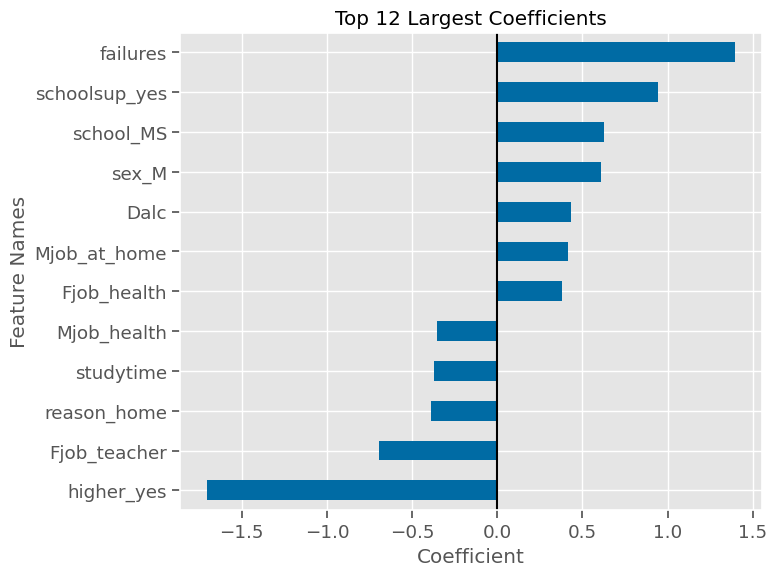

In [227]:
ax = plot_coeffs(coeffs,top_n=12)

## Comparing Linear and Logistic Regression Coefficients


In [231]:
#A custom function used to annotate bar values, used in plot_coeffs()
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    #ax.patches allows you to customize your bars
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
     
        #ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

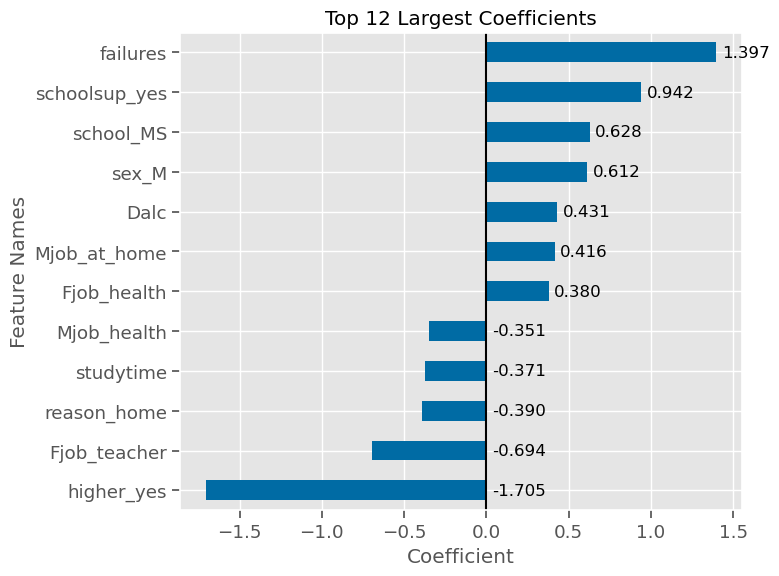

In [232]:
ax = plot_coeffs(coeffs,top_n=12,annotate=True)

### Converting Log-Odds to Odds

In [228]:
## logodds coeff for failures
coeffs.loc['failures']

1.396814206328028

In [229]:
## Raising e to the power of our logodds coeff 
import math
math.e**coeffs.loc['failures']

4.042301493298605

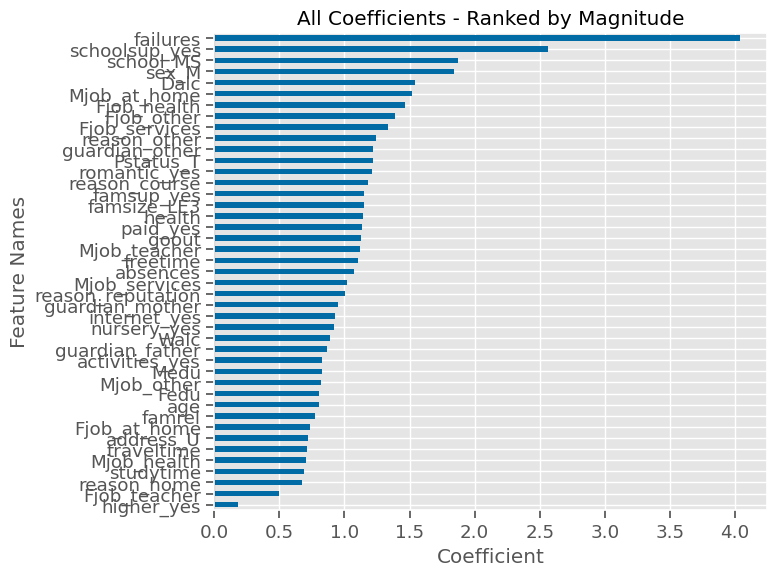

In [239]:
#This returns the "odds" of being in the positive class (in our case - the odds of failing vs passing).
#By using np.exp(), we can do this to our entire series at once:
coeffs_odds = np.exp(coeffs)
plot_coeffs(coeffs_odds);

### Updating our function


In [240]:
#add a boolean argument for if we want to convert the log-odds into odds right away
def get_coeffs_logreg(logreg, feature_names = None, sort=True,ascending=True,
                      name='LogReg Coefficients', class_index=0,  
                      include_intercept=False, as_odds=False):
    
    if feature_names is None:
        feature_names = logreg.feature_names_in_
        
    ## Saving the coefficients
    coeffs = pd.Series(logreg.coef_[class_index],
                       index= feature_names, name=name)
    
    if include_intercept:
        # use .loc to add the intercept to the series
        coeffs.loc['intercept'] = logreg.intercept_[class_index]
        
    if as_odds==True:
        coeffs = np.exp(coeffs)
    if sort == True:
        coeffs = coeffs.sort_values(ascending=ascending)
    
        
    return coeffs

In [241]:
coeffs_odds = get_coeffs_logreg(logreg, as_odds=True)
coeffs_odds

higher_yes           0.181724
Fjob_teacher         0.499605
reason_home          0.677349
studytime            0.689850
Mjob_health          0.704231
traveltime           0.713965
address_U            0.722753
Fjob_at_home         0.738591
famrel               0.773794
age                  0.802302
Fedu                 0.806085
Mjob_other           0.820962
Medu                 0.829871
activities_yes       0.829910
guardian_father      0.866506
Walc                 0.889059
nursery_yes          0.923201
internet_yes         0.929286
guardian_mother      0.946775
reason_reputation    1.002138
Mjob_services        1.016240
absences             1.075037
freetime             1.107495
Mjob_teacher         1.121387
goout                1.130251
paid_yes             1.132973
health               1.142136
famsize_LE3          1.148319
famsup_yes           1.148409
reason_course        1.182498
romantic_yes         1.211399
Pstatus_T            1.216400
guardian_other       1.217461
reason_oth

### Interpreting Odds


Odds are how much more likely to fall into the 1 class than the 0 class.
- A value of 1 means both classes are equally likely.
- A value > 1 means that the 1 class is more likely than the 0 class.
- A value < 1 means that the 1 class is less likely than the 0 class.

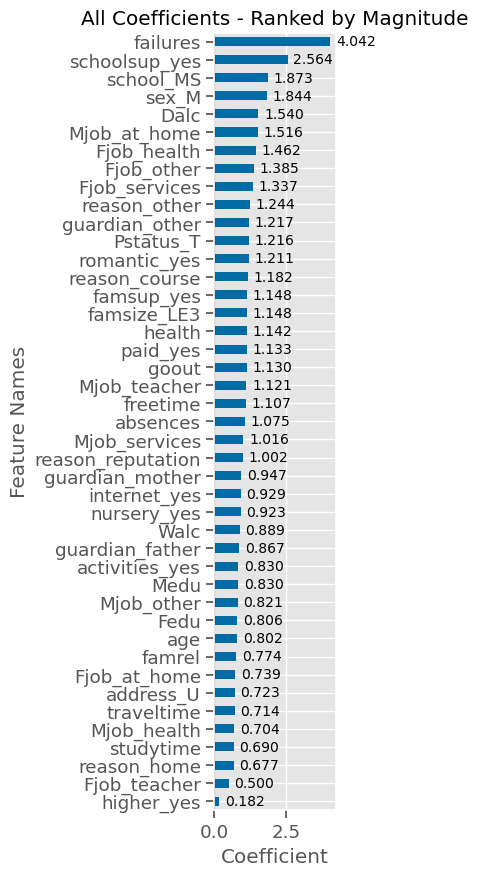

In [243]:
# shows how many times more likely is feature likely to be fail than not fail
coeffs_odds = get_coeffs_logreg(logreg, as_odds=True)
ax = plot_coeffs(coeffs_odds,annotate=True,figsize=(4,9),size=10)


### Interpreting Odds Coefficients


Let's walk through interpreting some of our largest odds coefficients:
failures:

* For every additional failure, the odds of a student failing is 4.043 times the odds of passing.
* schoolsup_yes: Getting (needing?) extra support from the school increases the odds of failing by 2.566
* school_MS: students who attend MS (and not GP) are 1.873 times more likely to fail.
* sex_M:male students are 1.844 times more likely to fail than female students.

## Presenting Logistic Regression Coefficients to Non-Technical Stakeholders

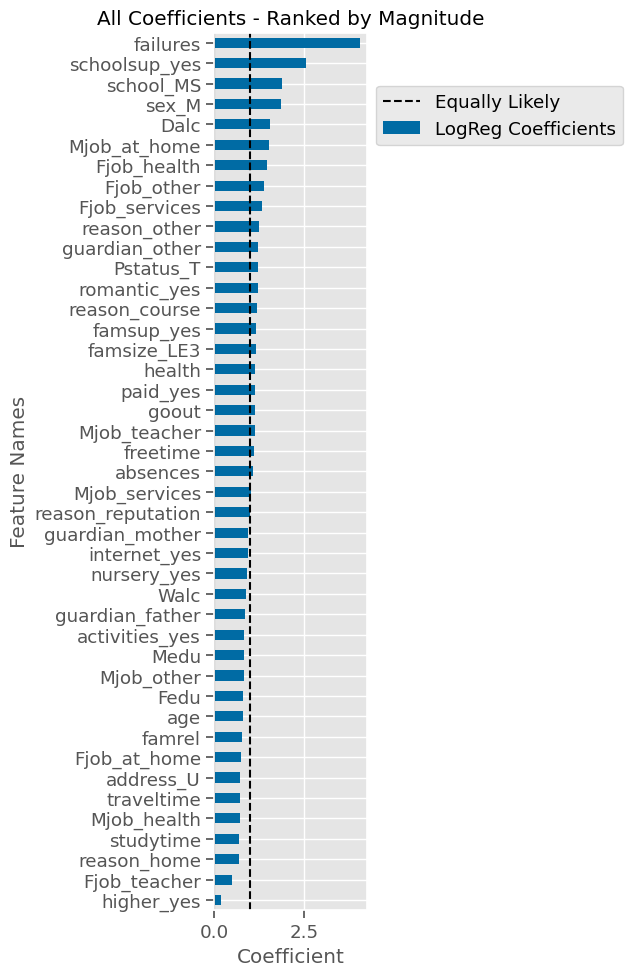

In [244]:
# add a vertical line at 1 (where 1= equally likely of Failing or Passing)
ax = plot_coeffs(coeffs_odds,annotate=False,figsize=(4,10))
ax.axvline(1, ls='--',label='Equally Likely',color='k', zorder=1)
ax.legend(bbox_to_anchor=[1,.95]);